In [50]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from matplotlib.lines import Line2D


In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [52]:
use_cuda = torch.cuda.is_available()

In [53]:
model = Net()

saved_model = torch.load("./model.pt", map_location=('cpu'))
model.load_state_dict(saved_model)
if use_cuda:
    torch.cuda.set_device(4)
    model = model.cuda()

In [54]:
sum(p.numel() for p in model.parameters())

62006

In [55]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='/datasets/cifar10/', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/datasets/cifar10/', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [56]:
fpath = "./"

fname = "low_curve_losses.pt"
low_curve_losses = torch.load(fpath + fname)

fname = "low_curve_losses_test.pt"
low_curve_losses_test = torch.load(fpath + fname)

fname = "n_diff_low.pt"
n_diff_low = torch.load(fpath + fname)

fname = "n_diff_low_test.pt"
n_diff_low_test = torch.load(fpath + fname)

fname = "high_curve_losses.pt"
high_curve_losses = torch.load(fpath + fname)

fname = "high_curve_losses_test.pt"
high_curve_losses_test = torch.load(fpath + fname)

fname = "n_diff_high.pt"
n_diff_high = torch.load(fpath + fname)

fname = "n_diff_high_test.pt"
n_diff_high_test = torch.load(fpath + fname)

ntrain = 50000
ntest = 10000

In [57]:
std_low_loss = low_curve_losses.std(-1)
std_low_loss_test = low_curve_losses_test.std(-1)

std_low_diff = n_diff_low.std(-1)
std_low_diff_test = n_diff_low_test.std(-1)

std_high_loss = high_curve_losses.std(-1)
std_high_loss_test = high_curve_losses_test.std(-1)

std_high_diff = n_diff_high.std(-1)
std_high_diff_test = n_diff_high_test.std(-1)


In [68]:
def plot_curve(dat, npts, axis, cind, ls, errors=True):
    curve = dat.mean(-1).div(npts)    

    ax[axis].plot(scales, curve,
        color=colors[cind], linestyle=ls)
    
    if errors:
        stdev = dat.div(npts).std(-1)
        ax[axis].fill_between(scales, curve - stdev, curve + stdev,
                alpha=0.15, color=colors[cind])

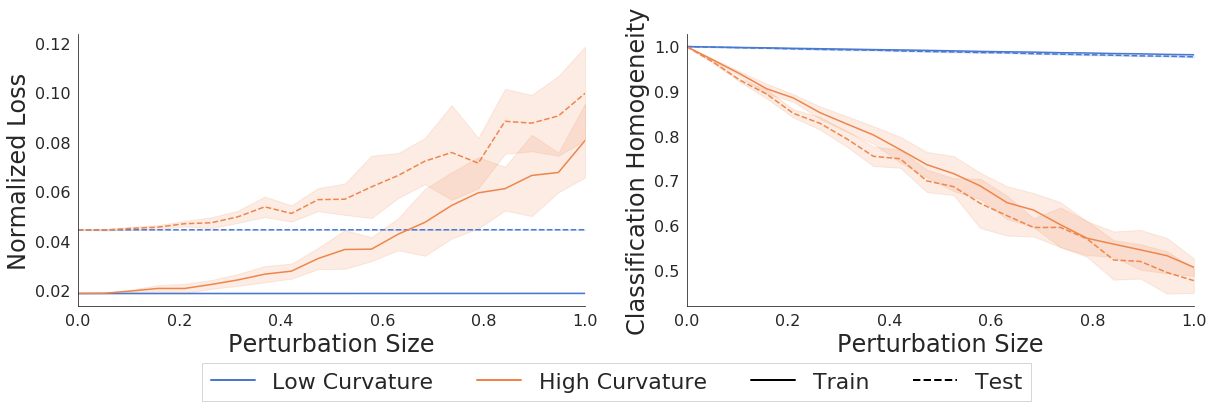

In [90]:
sns.set_style("white")
colors = sns.color_palette("muted")

scales = torch.linspace(0, 1., low_curve_losses.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
plot_curve(low_curve_losses, ntrain, 
           axis=0, cind=0, ls="-",
           errors=True)
plot_curve(low_curve_losses_test, ntest, 
           axis=0, cind=0, ls="--",
           errors=True)
plot_curve(high_curve_losses, ntrain, 
           axis=0, cind=1, ls="-",
           errors=True)
plot_curve(high_curve_losses_test, ntest,
           axis=0, cind=1, ls="--",
           errors=True)

plot_curve(ntrain - n_diff_low, ntrain, 
           axis=1, cind=0, ls="-",
           errors=True)
plot_curve(ntest - n_diff_low_test, ntest, 
           axis=1, cind=0, ls="--",
           errors=True)
plot_curve(ntrain - n_diff_high, ntrain, 
           axis=1, cind=1, ls="-",
           errors=True)
plot_curve(ntest - n_diff_high_test, ntest,
           axis=1, cind=1, ls="--",
           errors=True)

sns.despine()

leg_fs = 22
title_fs = 26
axis_fs = 24
tick_fs = 16
ax[0].tick_params('both', labelsize=tick_fs)
ax[1].tick_params('both', labelsize=tick_fs)

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)

ax[0].set_xlabel("Perturbation Size", fontsize=axis_fs)
ax[0].set_ylabel("Normalized Loss", fontsize=axis_fs)
ax[1].set_xlabel("Perturbation Size", fontsize=axis_fs)
ax[1].set_ylabel("Classification Homogeneity", fontsize=axis_fs)

fig.subplots_adjust(wspace=0.2)

custom_lines = [Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], color='k', lw=2, linestyle="--")]
ax[1].legend(custom_lines, ["Low Curvature", "High Curvature", "Train", "Test"],
            bbox_to_anchor=(0.7, -0.17),fancybox=False, shadow=False, ncol=4,
            fontsize=leg_fs)
plt.savefig("./cifar_homog.pdf", bbox_inches="tight")

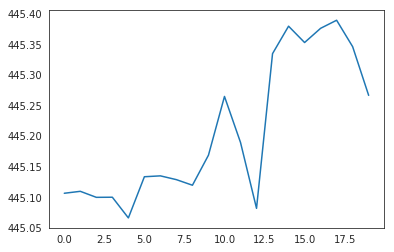

In [60]:
plt.plot(low_curve_losses_test.mean(-1))

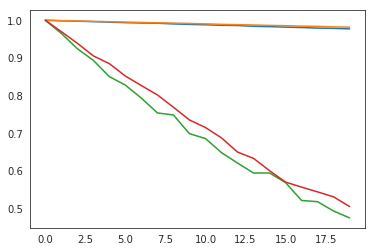

In [61]:
plt.plot(1 - n_diff_low_test.mean(-1).div(10000))
plt.plot(1 - n_diff_low.mean(-1).div(50000))

plt.plot(1 - n_diff_high_test.mean(-1).div(10000))
plt.plot(1 - n_diff_high.mean(-1).div(50000))